In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [3]:
tf.random.set_seed(47)
np.random.seed(47)

In [4]:
# !pip install optuna > /dev/null

In [5]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [6]:
plt.rcParams['figure.figsize'] = (16,6)

In [7]:
df = pd.read_csv('../input/stockdata/ADBL_data.csv')
df['Date'] = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Open,High,Low,Close
0,2012-01-01,115.0,115.0,113.0,114.0
1,2012-01-02,114.0,118.0,115.0,118.0
2,2012-01-03,118.0,116.0,114.0,115.0
3,2012-01-04,115.0,115.0,113.0,114.0
4,2012-01-05,114.0,114.0,112.0,113.0


Using only Date and Close

In [9]:
df = df[['Date', 'Close']]

In [10]:
df.describe()

,Close
count,1911.00000
mean,406.92831
std,167.13069
min,101.00000
25%,313.00000
50%,420.00000
75%,480.00000
max,1082.00000


In [11]:
df.head()

,Date,Close
0,2012-01-01,114.0
1,2012-01-02,118.0
2,2012-01-03,115.0
3,2012-01-04,114.0
4,2012-01-05,113.0


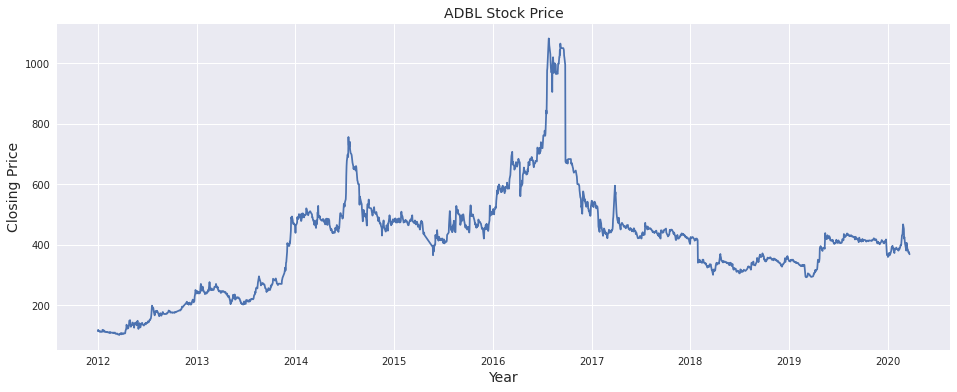

In [12]:
plt.title('ADBL Stock Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.plot(df['Date'], df['Close'])
plt.show()

# Generating features from target variable

In [13]:
# Percentage change is : (Todays price - yesterdays price) / yesterdays price
# For instance: (658.0 - 661.0) / 661.0
df['returns'] = df.Close.pct_change() * 100

In [14]:
# Generate Simple moving averages over the period of 10, 15, 20 and 30 days
for period in [10, 15, 20, 30]:
    column = f'sma_{period}'
    df[column] = df[['Close']].rolling(period).mean()

In [15]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
df.head()

,Date,Close,returns,sma_10,sma_15,sma_20,sma_30
0,2012-02-14,109.0,0.925926,109.8,110.533333,111.70,112.300000
1,2012-02-15,111.0,1.834862,109.8,110.466667,111.70,112.200000
2,2012-02-16,108.0,-2.702703,109.5,110.066667,111.45,111.866667
3,2012-02-21,109.0,0.925926,109.4,109.866667,111.00,111.666667
4,2012-02-23,109.0,0.000000,109.2,109.666667,110.60,111.500000


In [17]:
data = df[['Close', 'returns', 'sma_10', 'sma_15', 'sma_20', 'sma_30']].values
data

array([[109.        ,   0.92592593, 109.8       , 110.53333333,
        111.7       , 112.3       ],
       [111.        ,   1.83486239, 109.8       , 110.46666667,
        111.7       , 112.2       ],
       [108.        ,  -2.7027027 , 109.5       , 110.06666667,
        111.45      , 111.86666667],
       ...,
       [374.        ,  -1.05820106, 394.5       , 411.46666667,
        411.4       , 402.93333333],
       [376.        ,   0.53475936, 389.6       , 407.53333333,
        410.3       , 402.6       ],
       [368.        ,  -2.12765957, 384.8       , 401.86666667,
        408.85      , 402.03333333]])

# Train, validation and test split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_data = train_test_split(data, test_size=0.20, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(1505, 6)
(188, 6)
(189, 6)


# Scaling input data

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Generating input features based on time step

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)


Train Samples: 1504
Validation Samples: 187
Test Samples: 188


# Scaling back output data to original Closing price

In [24]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [25]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(1504,) (187,) (188,)


In [26]:
x_train[1], y_train[0]

(array([[0.01019368, 0.80633345, 0.00657965, 0.00666619, 0.00774475,
         0.00736974]]),
 0.010193679918450563)

In [27]:
x_val[1], y_val[0]

(array([[0.25993884, 0.84555257, 0.25002653, 0.25180991, 0.25066812,
         0.24828654]]),
 0.25993883792048933)

In [28]:
x_test[1], y_test[0]

(array([[0.3088685 , 0.72241604, 0.33057413, 0.33761021, 0.34278702,
         0.33746039]]),
 0.308868501529052)

# LSTM Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras import optimizers

## Hyperparameter Search

In [30]:
early_stopping_rounds = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)

In [31]:
# Objective function
def run(trial):
    space = {
        'optimizer':  trial.suggest_categorical('optimizer', [optimizers.Adam, optimizers.Adagrad, optimizers.Adamax, optimizers.Nadam, optimizers.RMSprop, optimizers.SGD]),
        'units': trial.suggest_int('units', 50, 4000, 50),
        'epochs': trial.suggest_int('epochs', 100, 5000, 50),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.6),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 8e-1)
    }

    model = Sequential()
    # Adding the LSTM layer and some Dropout regularization
    model.add(LSTM(units=space['units'], input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(rate=space['dropout_rate']))
    # Adding the output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(loss='mean_squared_error', optimizer=space['optimizer'](learning_rate=space['learning_rate']), metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=space['epochs'], validation_data=(x_val, y_val), batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_train = np.squeeze(model.predict(x_train))
    yhat_val = np.squeeze(model.predict(x_val))

    yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
    yhat_val = scaler.inverse_transform(prep_data_transform(yhat_val, X_val.shape[1]))[:,0]

    nan_check = [np.isnan(yhat_train).any(), np.isnan(yhat_val).any()]
    print(nan_check)
    if True in nan_check:
        rmse = 99999
    else:
        rmse = mean_squared_error(Y_val, yhat_val, squared=False)
    return rmse

In [32]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=50)

[I 2021-11-01 10:56:09,453] A new study created in memory with name: no-name-39bad72e-d48a-45f1-92ac-47d4dcbce305
2021-11-01 10:56:09.524897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 10:56:09.612970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 10:56:09.613721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 10:56:09.615575: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critica

[False, False]


[I 2021-11-01 10:59:20,044] Trial 1 finished with value: 15.017938150144689 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 800, 'epochs': 3650, 'batch_size': 256, 'dropout_rate': 0.5993230998178881, 'learning_rate': 0.0035606273409323503}. Best is trial 0 with value: 8.000573384910622.


[False, False]


[I 2021-11-01 10:59:27,311] Trial 2 finished with value: 9.951816168531888 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 550, 'epochs': 150, 'batch_size': 512, 'dropout_rate': 0.15578277554668327, 'learning_rate': 0.006359717268853655}. Best is trial 0 with value: 8.000573384910622.


[False, False]


[I 2021-11-01 11:01:52,338] Trial 3 finished with value: 6.722416771065011 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 850, 'epochs': 4500, 'batch_size': 64, 'dropout_rate': 0.11350238114543118, 'learning_rate': 0.3215035177852704}. Best is trial 3 with value: 6.722416771065011.


[False, False]


[I 2021-11-01 11:03:33,395] Trial 4 finished with value: 14.451366636079554 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 2700, 'epochs': 3700, 'batch_size': 512, 'dropout_rate': 0.28664684684787356, 'learning_rate': 0.0020629050344263236}. Best is trial 3 with value: 6.722416771065011.


[False, False]


[I 2021-11-01 11:28:15,878] Trial 5 finished with value: 7.528329534258227 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 3550, 'epochs': 2900, 'batch_size': 16, 'dropout_rate': 0.24943334959408017, 'learning_rate': 0.022840016584194538}. Best is trial 3 with value: 6.722416771065011.


[False, False]


[I 2021-11-01 11:32:01,415] Trial 6 finished with value: 9.835236310284436 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 800, 'epochs': 1050, 'batch_size': 16, 'dropout_rate': 0.2278313277743029, 'learning_rate': 0.016025552061195485}. Best is trial 3 with value: 6.722416771065011.


[False, False]


[I 2021-11-01 11:33:25,337] Trial 7 finished with value: 8.067290055952633 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 250, 'epochs': 4500, 'batch_size': 512, 'dropout_rate': 0.23345661081897492, 'learning_rate': 0.004734740395723211}. Best is trial 3 with value: 6.722416771065011.


[False, False]


[I 2021-11-01 11:45:10,651] Trial 8 finished with value: 6.575061269427753 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 2900, 'epochs': 4250, 'batch_size': 64, 'dropout_rate': 0.30787234906523664, 'learning_rate': 0.036716523957494064}. Best is trial 8 with value: 6.575061269427753.


[False, False]


[I 2021-11-01 11:48:24,243] Trial 9 finished with value: 9.540222346522016 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 4000, 'epochs': 2550, 'batch_size': 512, 'dropout_rate': 0.4878364675889951, 'learning_rate': 0.002703351254912793}. Best is trial 8 with value: 6.575061269427753.


[False, False]


[I 2021-11-01 11:50:45,160] Trial 10 finished with value: 6.216676243777816 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2150, 'epochs': 1850, 'batch_size': 128, 'dropout_rate': 0.3554646275171751, 'learning_rate': 0.19458381551526188}. Best is trial 10 with value: 6.216676243777816.


[False, False]


[I 2021-11-01 11:53:22,793] Trial 11 finished with value: 6.2039818343394115 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2050, 'epochs': 1400, 'batch_size': 128, 'dropout_rate': 0.3597842072699491, 'learning_rate': 0.1378263982635028}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 11:55:07,210] Trial 12 finished with value: 6.249278436334485 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 1800, 'epochs': 1650, 'batch_size': 128, 'dropout_rate': 0.39168324507158714, 'learning_rate': 0.21251024225410173}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 11:58:52,099] Trial 13 finished with value: 6.581637671746929 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2150, 'epochs': 1850, 'batch_size': 128, 'dropout_rate': 0.4899410645477966, 'learning_rate': 0.0942416712477673}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:01:20,516] Trial 14 finished with value: 6.42661499144742 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 1750, 'epochs': 1900, 'batch_size': 128, 'dropout_rate': 0.35774426515687563, 'learning_rate': 0.7998833592057072}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:07:57,130] Trial 15 finished with value: 6.205681375674437 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2450, 'epochs': 1250, 'batch_size': 32, 'dropout_rate': 0.46176037925455327, 'learning_rate': 0.07626828016143894}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:16:41,273] Trial 16 finished with value: 6.21154720330262 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2850, 'epochs': 1000, 'batch_size': 32, 'dropout_rate': 0.45370452345003043, 'learning_rate': 0.06271112923668198}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:18:07,676] Trial 17 finished with value: 70.22675673681637 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 1400, 'epochs': 2400, 'batch_size': 32, 'dropout_rate': 0.5702238297814894, 'learning_rate': 0.09965792216219245}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:21:27,390] Trial 18 finished with value: 102.42545084035036 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 2500, 'epochs': 1300, 'batch_size': 32, 'dropout_rate': 0.5186392158573038, 'learning_rate': 0.7621418851660401}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:22:26,932] Trial 19 finished with value: 13.754486417352219 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3300, 'epochs': 200, 'batch_size': 256, 'dropout_rate': 0.4292188608574357, 'learning_rate': 0.04249167347366148}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:26:01,311] Trial 20 finished with value: 7.706598200832019 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2400, 'epochs': 3100, 'batch_size': 32, 'dropout_rate': 0.5426126163569575, 'learning_rate': 0.1302053461272897}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:33:49,042] Trial 21 finished with value: 6.204792894657083 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3100, 'epochs': 850, 'batch_size': 32, 'dropout_rate': 0.4501085526294226, 'learning_rate': 0.049133160920277336}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:40:42,973] Trial 22 finished with value: 6.219923635686681 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3300, 'epochs': 650, 'batch_size': 32, 'dropout_rate': 0.39544834775977844, 'learning_rate': 0.0538599990611971}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:48:32,625] Trial 23 finished with value: 6.239944769489406 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3150, 'epochs': 1400, 'batch_size': 32, 'dropout_rate': 0.46782950581326554, 'learning_rate': 0.2999256914359242}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 12:57:01,205] Trial 24 finished with value: 8.372021555190111 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3700, 'epochs': 700, 'batch_size': 32, 'dropout_rate': 0.32633203649710385, 'learning_rate': 0.010166127184325153}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:00:00,253] Trial 25 finished with value: 6.617067285189542 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 1700, 'epochs': 2150, 'batch_size': 128, 'dropout_rate': 0.39222091831236766, 'learning_rate': 0.02749105198637923}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:08:36,817] Trial 26 finished with value: 7.324663452739489 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 2450, 'epochs': 1350, 'batch_size': 32, 'dropout_rate': 0.5116207773289106, 'learning_rate': 0.0012726515834607737}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:10:42,235] Trial 27 finished with value: 10.05453676272022 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 1950, 'epochs': 900, 'batch_size': 16, 'dropout_rate': 0.42694866140971727, 'learning_rate': 0.0721491370612069}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:12:25,053] Trial 28 finished with value: 9.260484233141144 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 2950, 'epochs': 400, 'batch_size': 128, 'dropout_rate': 0.369546346844431, 'learning_rate': 0.41835407270443253}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:13:11,264] Trial 29 finished with value: 7.780409866788174 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 1450, 'epochs': 450, 'batch_size': 256, 'dropout_rate': 0.45310272714707606, 'learning_rate': 0.15809203577350245}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:20:46,017] Trial 30 finished with value: 6.361101344794099 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2300, 'epochs': 1500, 'batch_size': 32, 'dropout_rate': 0.27058379784587905, 'learning_rate': 0.016223909699999445}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:27:14,329] Trial 31 finished with value: 6.693083683523599 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2800, 'epochs': 1100, 'batch_size': 32, 'dropout_rate': 0.4541426094534541, 'learning_rate': 0.0655333291057305}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:33:54,810] Trial 32 finished with value: 6.3747160800766025 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2650, 'epochs': 800, 'batch_size': 32, 'dropout_rate': 0.41681604625560453, 'learning_rate': 0.09245780202063765}. Best is trial 11 with value: 6.2039818343394115.


[False, False]


[I 2021-11-01 13:44:43,106] Trial 33 finished with value: 6.18883611539602 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3050, 'epochs': 1150, 'batch_size': 32, 'dropout_rate': 0.5159648297723926, 'learning_rate': 0.04226785617147533}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 13:54:39,451] Trial 34 finished with value: 7.024176984645631 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 3200, 'epochs': 2100, 'batch_size': 64, 'dropout_rate': 0.596413471847864, 'learning_rate': 0.03415734326163842}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 13:56:36,471] Trial 35 finished with value: 14.387521463245529 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3550, 'epochs': 500, 'batch_size': 256, 'dropout_rate': 0.5355149375381029, 'learning_rate': 0.010549985225397521}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 13:58:25,140] Trial 36 finished with value: 11.002800547048146 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 3050, 'epochs': 100, 'batch_size': 32, 'dropout_rate': 0.18281573849244456, 'learning_rate': 0.02506369791401511}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 14:05:06,065] Trial 37 finished with value: 16.528057114467387 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 2650, 'epochs': 1150, 'batch_size': 16, 'dropout_rate': 0.48942584122460736, 'learning_rate': 0.04434924163894888}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 14:07:31,138] Trial 38 finished with value: 6.345857569092492 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units': 1050, 'epochs': 5000, 'batch_size': 64, 'dropout_rate': 0.5655912801189515, 'learning_rate': 0.1164291944542648}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 14:13:00,771] Trial 39 finished with value: 10.847717731228887 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3500, 'epochs': 2850, 'batch_size': 512, 'dropout_rate': 0.3289392021337164, 'learning_rate': 0.020512044064178326}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 14:14:49,258] Trial 40 finished with value: 193.14044636795975 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units': 2000, 'epochs': 1700, 'batch_size': 32, 'dropout_rate': 0.4136296315481266, 'learning_rate': 0.2548270675433944}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 14:23:17,929] Trial 41 finished with value: 6.369732455822955 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2850, 'epochs': 1050, 'batch_size': 32, 'dropout_rate': 0.4568946466630008, 'learning_rate': 0.06571999605788775}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 14:26:24,155] Trial 42 finished with value: 6.343394447112958 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2250, 'epochs': 900, 'batch_size': 32, 'dropout_rate': 0.5131793197519229, 'learning_rate': 0.14645661403015459}. Best is trial 33 with value: 6.18883611539602.


[False, False]


[I 2021-11-01 14:35:04,832] Trial 43 finished with value: 6.184800278898629 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2650, 'epochs': 1550, 'batch_size': 32, 'dropout_rate': 0.49102876393839134, 'learning_rate': 0.0511808728165082}. Best is trial 43 with value: 6.184800278898629.


[False, False]


[I 2021-11-01 14:39:24,435] Trial 44 finished with value: 6.799370851774023 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2650, 'epochs': 1550, 'batch_size': 128, 'dropout_rate': 0.48046058998734914, 'learning_rate': 0.03449820793558672}. Best is trial 43 with value: 6.184800278898629.


[False, False]


[I 2021-11-01 15:01:36,448] Trial 45 finished with value: 62.406078686384774 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units': 4000, 'epochs': 1200, 'batch_size': 32, 'dropout_rate': 0.5506190261021177, 'learning_rate': 0.05065654237586474}. Best is trial 43 with value: 6.184800278898629.


[False, False]


[I 2021-11-01 15:05:28,638] Trial 46 finished with value: 6.63300773829422 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 3800, 'epochs': 2350, 'batch_size': 512, 'dropout_rate': 0.5064516410378591, 'learning_rate': 0.4451948382674125}. Best is trial 43 with value: 6.184800278898629.


[False, False]


[I 2021-11-01 15:07:29,978] Trial 47 finished with value: 7.071926643493588 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units': 2550, 'epochs': 2000, 'batch_size': 128, 'dropout_rate': 0.43751511466744364, 'learning_rate': 0.07798929677027511}. Best is trial 43 with value: 6.184800278898629.


[False, False]


[I 2021-11-01 15:51:18,587] Trial 48 finished with value: 7.795506928752402 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units': 3050, 'epochs': 1650, 'batch_size': 16, 'dropout_rate': 0.37168204579483816, 'learning_rate': 0.005621633508294643}. Best is trial 43 with value: 6.184800278898629.


[False, False]


[I 2021-11-01 15:54:51,059] Trial 49 finished with value: 6.460195758744568 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units': 2200, 'epochs': 3650, 'batch_size': 64, 'dropout_rate': 0.5909974736991152, 'learning_rate': 0.18212177573228167}. Best is trial 43 with value: 6.184800278898629.


[False, False]
CPU times: user 2h 18min 40s, sys: 13min 17s, total: 2h 31min 58s
Wall time: 4h 58min 41s


In [33]:
best_params = study.best_params
best_params

{'optimizer': keras.optimizer_v2.adagrad.Adagrad,
 'units': 2650,
 'epochs': 1550,
 'batch_size': 32,
 'dropout_rate': 0.49102876393839134,
 'learning_rate': 0.0511808728165082}

In [34]:
# best_params = {
#     'optimizer': optimizers.Adagrad,
#     'units': 1300,
#     'epochs': 1250,
#     'batch_size': 16,
#     'dropout_rate': 0.4424634570372381,
#     'learning_rate': 0.06875747699605214
# }

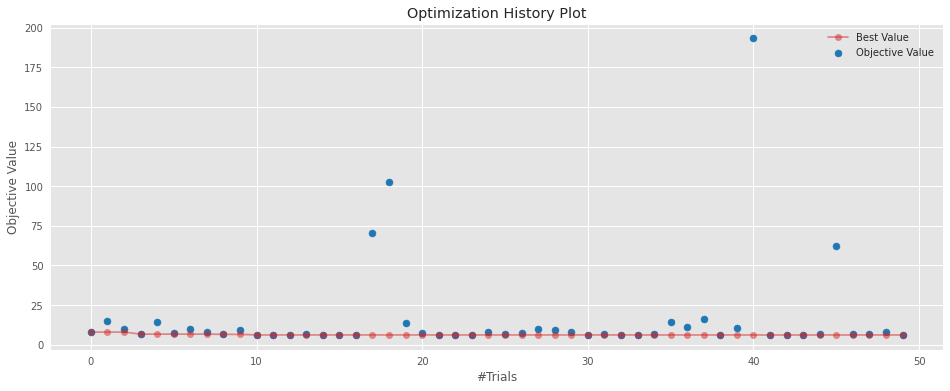

In [35]:
plot_optimization_history(study);

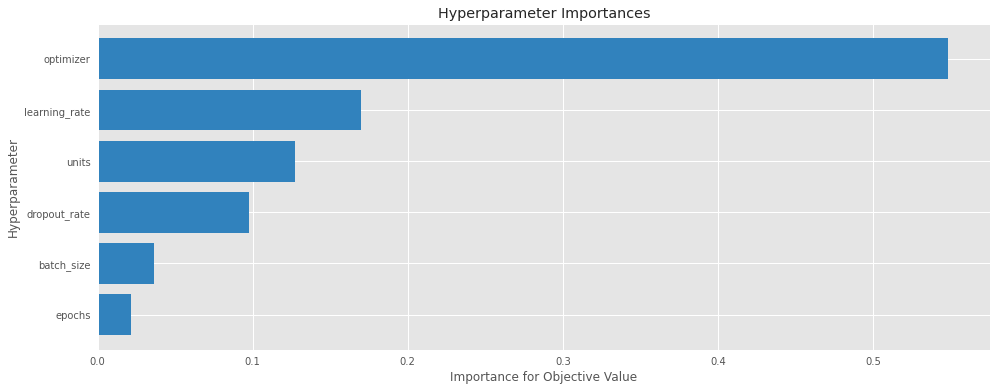

In [36]:
plot_param_importances(study);

In [37]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

## Model Training

In [38]:
model = Sequential()
model.add(LSTM(units=best_params['units'], input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=best_params['dropout_rate']))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=best_params['optimizer'](learning_rate=best_params['learning_rate']), metrics=['accuracy'])
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 2650)              28164200  
_________________________________________________________________
dropout_50 (Dropout)         (None, 2650)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 2651      
Total params: 28,166,851
Trainable params: 28,166,851
Non-trainable params: 0
_________________________________________________________________


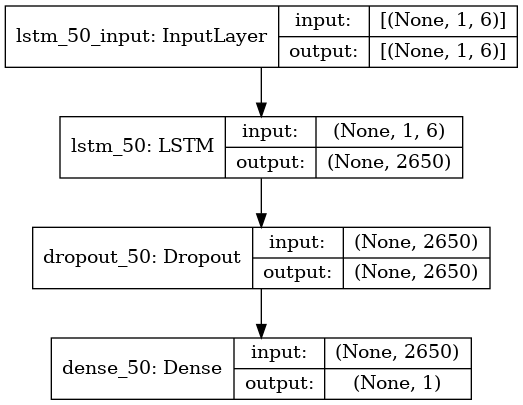

In [39]:
plot_model(model, show_shapes=True)

In [40]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 5min 36s, sys: 29.9 s, total: 6min 6s
Wall time: 10min 43s


## Model Evaluation

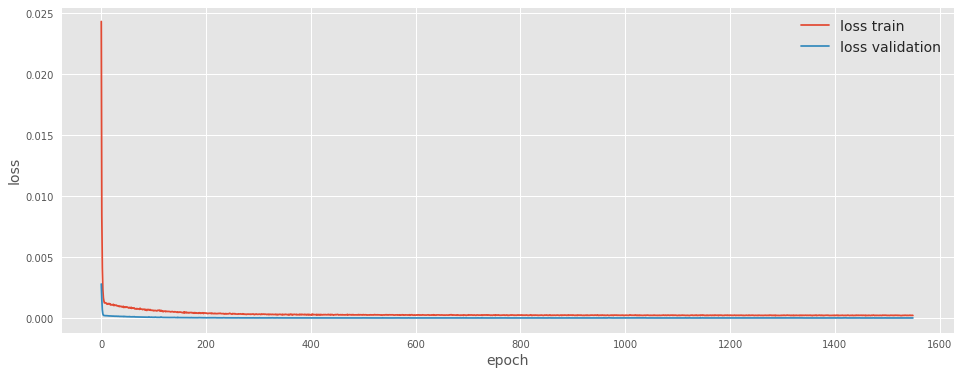

In [41]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [42]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

6/6 [==============================] - 0s 5ms/step - loss: 5.7555e-05 - accuracy: 0.0000e+00


[5.755474921897985e-05, 0.0]

## Prediction

In [43]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

In [44]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(1504,) (188,)


In [45]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [111.44878434 113.87828782 108.35696673 111.44444278 110.8936643 ]
Train Actual:  [111. 108. 109. 109. 107.]
Test Predicted:  [411.86447197 404.63374662 404.3139624  403.17793611 405.42765233]
Test Actual:  [404. 403. 402. 404. 406.]


## Loss Analysis

In [46]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.66 RMSE
Test Score: 7.44 RMSE


## Plotting Predictions

In [47]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

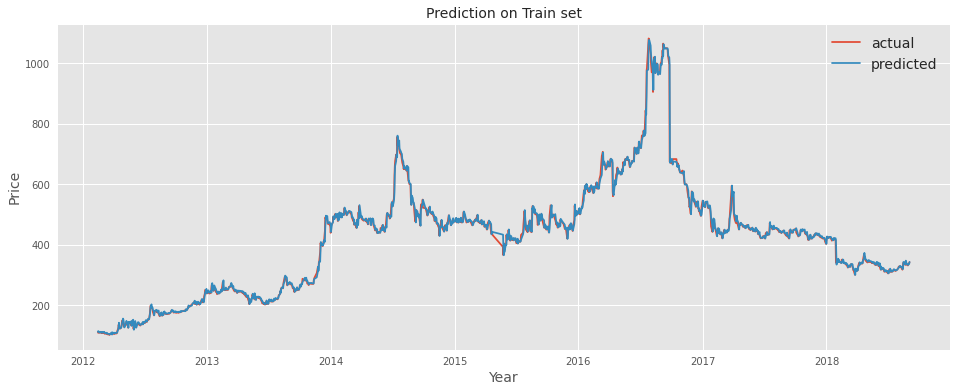

In [48]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

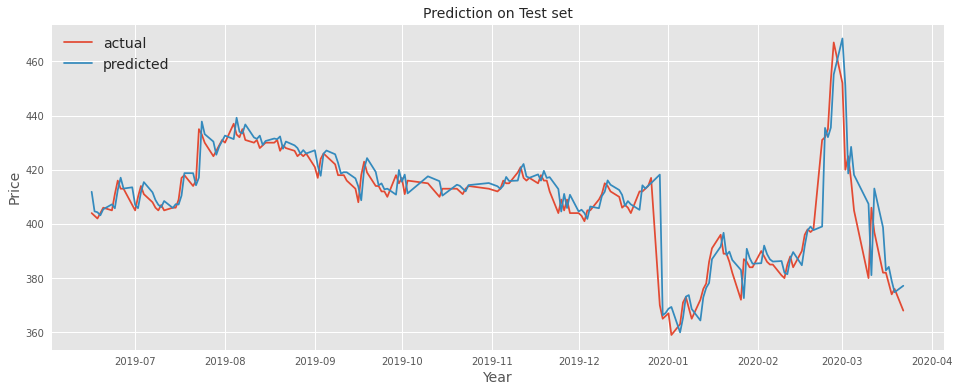

In [49]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()